In [2]:
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

Next, let's create the simulated data. Eventually I am going to burn the initial segment of the data. There are other ways I could generate the data, this is just more intuitive and easier to exaplain to others.

In [3]:
size=2100
w=[]
x=[]
y=[]
z=[]

while len(z)<size:
    if len(z)<3:
        w.append(stats.norm(12, 3).rvs(1))
        x.append(stats.poisson(20).rvs(1))
        y.append(stats.norm(15, 3).rvs(1))
        z.append(stats.poisson(30).rvs(1))
    else:
        w.append(stats.norm(12, 3).rvs(1)) # w is exog
        x.append(stats.poisson(20).rvs(1)) # x is exog
        y.append(0.2*w[-1]-0.4*x[-1]+0.03*y[-1]+0.05*z[-1]+stats.norm(0, 5).rvs(1)) # y is endog
        z.append(0.8*w[-1]+0.3*x[-1]+1.2*y[-1]+0.025*z[-1]+stats.norm(0, 5).rvs(1)) # z is endog



Y=[y, z]
X=[w, x, ylag1, zlag1]
A is 2x2
B is 2x4
\begin{equation}
AY=BX
\end{equation}

In [4]:
A=np.asarray([[1, -0.05], [-1.2, 1]])
B=np.asarray([[0.2, -0.4, 0.03, 0], [0.8, 0.3, 0, 0.025]])
C=np.linalg.inv(A)@B

In [5]:
C

array([[ 0.25531915, -0.40957447,  0.03191489,  0.00132979],
       [ 1.10638298, -0.19148936,  0.03829787,  0.02659574]])

In [6]:
ylag1=[]
zlag1=[]
for i in range(1,len(y)): # creating the lagged variables
    ylag1.append(y[i-1])
    zlag1.append(z[i-1])

In [7]:
#that's pretty much all the variables.

In [8]:
# burn early entries
w=np.asarray(w[100:])
x=np.asarray(x[100:])
y=np.asarray(y[100:])
z=np.asarray(z[100:])
ylag1=np.asarray(ylag1[99:])
zlag1=np.asarray(zlag1[99:])
# 1 less for the lag, so that each vector is of equal size

The equations are
\begin{equation}
y_t=\alpha_{11}*w_t+\alpha_{12}*x_t+\gamma_{13}*y_{t-1}+\gamma_{14}*z_t
\end{equation}

and 

\begin{equation}
z_t=\alpha_{21}*w_t+\alpha_{22}*x_t+\gamma_{23}*y_{t}+\gamma_{24}*z_{t-1}
\end{equation}

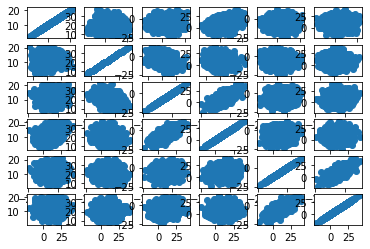

In [9]:
f, ax=plt.subplots(6, 6)

varname=np.column_stack((w, x, y, z, ylag1, zlag1))
for i in range(6):
    for j in range(6):
        ax[i, j].scatter(varname[:, i], varname[:, j])
        #plt.xlabel(varname[i])
        #plt.ylabel(varname[j])

#plt.tight_layout()
plt.show()

In [10]:
# estimate the two equations, one at a time by OLS
cons=np.ones((len(x), 1))
X1=np.column_stack((cons, w, x, ylag1, z)) # include the simultaneity as z_t
X2=np.column_stack((cons, w, x, y, zlag1)) # include the simultaneity as y_t
bols_1=np.linalg.inv(X1.T@X1)@X1.T@y
bols_2=np.linalg.inv(X2.T@X2)@X2.T@z

In [17]:
bols_1

array([[ 0.86448212],
       [-0.34076814],
       [-0.33235081],
       [ 0.01368245],
       [ 0.48769716]])

In [18]:
bols_2

array([[-0.60826033],
       [ 0.85235693],
       [ 0.30425253],
       [ 1.18932653],
       [ 0.01252036]])

Coefficients are all over the places.

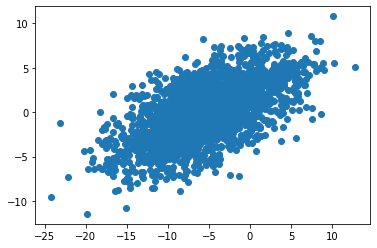

In [19]:
# lets look at the errors for the first equation
error1=y-(X1@bols_1)
plt.scatter(y, error1)
plt.show()

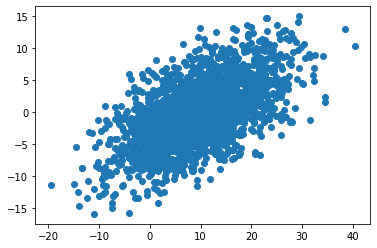

In [20]:
error2=z-(X2@bols_2)
plt.scatter(z, error2)
plt.show()

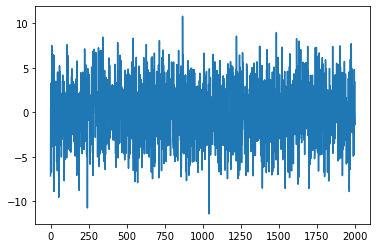

In [21]:
l=range(len(error1))
plt.plot(l, error1)
plt.show()

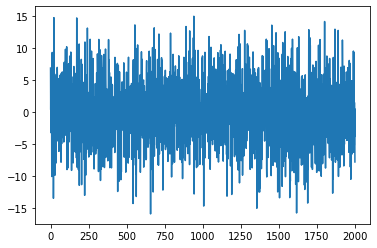

In [22]:
plt.plot(l, error2)
plt.show()

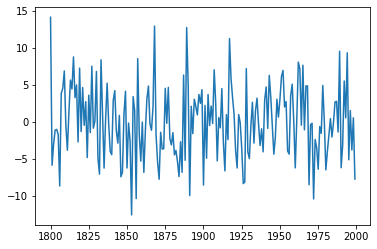

In [23]:
plt.plot(l[-200:], error2[-200:]) #zooming in to the graph for a better look
plt.show() # some kind of pattern in there

In [24]:
sigmahatsquare1=error1.T@error1/(len(error1)-1)
sigmahatsquare2=error2.T@error2/(len(error2)-1)
cov12=error1.T@error2/(len(error1)-1)

In [25]:
cov12

array([[-12.4763393]])

In [26]:
# cov matrix
cov=np.asarray([[sigmahatsquare1, cov12], [cov12, sigmahatsquare2]])

In [27]:
cov # would be useful for calculating the weights later.

array([[[[ 10.48084048]],

        [[-12.4763393 ]]],


       [[[-12.4763393 ]],

        [[ 25.56356141]]]])

Reduced forms

In [28]:
Xreduced=np.column_stack((cons, w, x, ylag1, zlag1)) #only the exogenous variables.
bols1_reduced=np.linalg.inv(Xreduced.T@Xreduced)@Xreduced.T@y
bols2_reduced=np.linalg.inv(Xreduced.T@Xreduced)@Xreduced.T@z

In [29]:
bols1_reduced

array([[ 0.89720266],
       [ 0.17775111],
       [-0.43687137],
       [ 0.01669988],
       [ 0.05143234]])

In [30]:
bols2_reduced

array([[ 0.91925166],
       [ 1.06362607],
       [-0.21466286],
       [ 0.0678594 ],
       [ 0.05141393]])

In [31]:
bols2_reduced.shape

(5, 1)

In [32]:
Q=np.asarray(np.linalg.inv(np.kron(cov, np.eye(len(y)))))

In [33]:
Q.shape

(2, 2, 2000, 2000)

In [34]:
q=np.reshape(Q, (4000, 4000)) # in case of simultaneity, this is the weighting matrix

In [35]:
# now, let's put all endog variables in one column
Y=np.row_stack((y, z))

In [36]:
len(Y)

4000

In [37]:
Z=np.kron(np.eye(2), Xreduced) # the 2x2 identity matrix for 2 endogenous variables
Z.shape

(4000, 10)

In [38]:
BReduced=np.linalg.inv(Z.T@Z)@Z.T@Y

In [39]:
BReduced #same as before, first half like bols1_reduced, second half like bols2_reduced

array([[ 0.89720266],
       [ 0.17775111],
       [-0.43687137],
       [ 0.01669988],
       [ 0.05143234],
       [ 0.91925166],
       [ 1.06362607],
       [-0.21466286],
       [ 0.0678594 ],
       [ 0.05141393]])

Let's consider an SUR type model- This is basically the VAR

In [40]:
O=np.zeros(len(y))

depvareq1=np.column_stack((cons, O, w, x, ylag1, z, O, O, O, O))
depvareq2=np.column_stack((O, cons, O, O, O, O, w, x, y, zlag1)) 
# it is slightly more complicated when arranging the variables in an SEM.
# if there were any symmetry conditions like demand estimation models, this organization
# of the row variables would be slightly different.
ZVAR=np.row_stack((depvareq1, depvareq2))

In [41]:
bVAR=np.linalg.inv(ZVAR.T@ZVAR)@ZVAR.T@Y # this is not weighted

In [42]:
bVAR

array([[ 0.86448212],
       [-0.60826033],
       [-0.34076814],
       [-0.33235081],
       [ 0.01368245],
       [ 0.48769716],
       [ 0.85235693],
       [ 0.30425253],
       [ 1.18932653],
       [ 0.01252036]])

In [43]:
from statsmodels.tsa.api import VAR

In [44]:
data=np.column_stack((y, z))
model=VAR(data)
res=model.fit(1) #one lag
res.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 10, Feb, 2020
Time:                     18:21:39
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    6.91396
Nobs:                     1999.00    HQIC:                   6.90332
Log likelihood:          -12560.6    FPE:                    989.451
AIC:                      6.89715    Det(Omega_mle):         986.488
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -5.764957         0.367183          -15.701           0.000
L1.y1         0.026291         0.032429            0.811           0.418
L1.y2         0.053722         0.020684            2.597           0.009

Results for equation 

This is benchmark.

In [45]:
bench1=np.column_stack((cons, O, ylag1, zlag1, O, O))
bench2=np.column_stack((O, cons, O, O, ylag1, zlag1))
benchdepvar=np.row_stack((bench1, bench2))

In [46]:
betacompare=np.linalg.inv(benchdepvar.T@benchdepvar)@benchdepvar.T@Y

In [47]:
betacompare

array([[-5.76963249],
       [ 9.44359941],
       [ 0.02609842],
       [ 0.0534964 ],
       [ 0.07405805],
       [ 0.05442208]])

Results Match. Note, how the constant term for equation 2 is actually the second coefficient.